# 作業工程計画
2023.1.5作成<br>
1. 受領データ（21、22夏）を結合
    参考：採点者品質予測_22秋後半納品_前処理_1025_v1.ipynb
2. 参加回数を修正
3. 欠損値を削除
4. 枠更新率を閾値（0.99）で01にしたフラグ追加

### DecisionTreeRegressorの概要
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor

### DecisionTreeClassifierの概要
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

### GradientBoostingRegressorの概要
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

### GradientBoostingClassifierの概要
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

### 混合行列（confusion matrix）
URL https://note.nkmk.me/python-sklearn-confusion-matrix-score/<br>
公式 https://seaborn.pydata.org/generated/seaborn.heatmap.html?highlight=heatmap#seaborn.heatmap<br>
seaborn https://evaluelog.com/post-122/#i-2

# ライブラリ追加

In [139]:
import pandas as pd
import numpy as np
import scipy as sp
import time
import matplotlib.pyplot as plt
import japanize_matplotlib
# import seaborn as sns
# import re 
"""
機械学習ライブラリの準備
"""

from sklearn.model_selection import cross_val_score
# from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report #2値分類評価指標を出力

from sklearn.tree import DecisionTreeRegressor #決定木
from sklearn.tree import DecisionTreeClassifier #決定木
import lightgbm as lgb #lightGBM

from sklearn import tree
import graphviz

In [2]:
"""
村上さんtoolbox
"""
# pandas 基礎集計クラス
import numpy as np
import pandas as pd
import copy
import seaborn as sns
from itertools import combinations

#http://qiita.com/tanemaki/items/2ed05e258ef4c9e6caac

# Jupyterで表示するためには、最初に以下を実行すること
%matplotlib inline

# Static Classで設計する
class pandas_tool:
    
    # All in one チェック（Jupyterのみ）
    def all_basic_summary_jupyter(df):
        print("■ 型の確認")
        display(pandas_tool.type(df))
        print("■ 数値型の確認")
        display(pandas_tool.summary(df)[0])
        print("■ カテゴリ型の確認")
        cate_var_data = list(df.select_dtypes(include=['object']).columns)
        ret = pandas_tool.freq(df,cate_var_data)
        for d in ret:
            display(pd.DataFrame(d))
            print("---------------")
        print("■ 欠損の確認")
        display(pandas_tool.check_missing(df))
    
    # 相関関係可視化（Jupyterのみ）
    def all_value_relation_visualize(df):
        #sns.set_context("poster", 1.2, {"lines.linewidth": 3})
        sns.pairplot(df,size=5)
    
    # カテゴリ変数でのヒートマップ（Jupyterのみ）
    def make_heatmap(df,x,y,value):
        target_df = df.pivot_table(index=x,values=value,columns=y)
        sns.heatmap(target_df, annot=True, fmt='1.1f', cmap='Blues')
    
    # 散布図（Jupyterのみ）
    def make_scatter_chart(df,x,y):
        #sns.jointplot(x=x, y=y, data=df, kind="hex")
        sns.jointplot(x=x, y=y, data=df)
    
    # 組み合わせでヒートマップを作成（Jupyterのみ）
    def all_make_heatmap(df,var_list,value):
        col_num = 2
        var_list_set = list(combinations(var_list,2))
        
        fig, axes = plt.subplots(int(len(var_list_set)/col_num)+1, col_num, figsize=(18,3+6.5*int(len(var_list_set)/col_num)))
        
        for i,target in enumerate(var_list_set):
            target_df = df.pivot_table(index=target[0],values=value,columns=target[1])
            sns.heatmap(target_df, annot=True, fmt='1.1f', cmap='Blues', ax=axes[int(i/col_num), i%col_num])
            
        plt.tight_layout()
    
    # 数値集計
    def summary(df,view=False):
        ret=df.describe()
        mis_ret=df.isnull().sum()
        if view:
            param=pd.get_option("display.max_columns")
            pd.set_option("display.max_columns",1000)
            print("・統計量")
            print(ret)
            print("・欠損値")
            print(mis_ret)
            pd.set_option("display.max_columns",param)
        return ret,mis_ret
    
    # 型チェック
    def type(df,view=False):
        ret = df.dtypes
        if view:
            param=pd.get_option("display.max_rows")
            pd.set_option("display.max_rows",1000)
            print(ret)
            pd.set_option("display.max_rows",param)
        return ret
    
    # 欠損チェック
    def check_missing(df,view=False):
        not_null_df=df.notnull()
        ret=pd.DataFrame()
        for name in not_null_df.columns:
            tmp_df=not_null_df[name].value_counts()
            tmp_df.name=name
            ret = pd.concat([ret,tmp_df],axis=1)
        
        if view:
            param=pd.get_option("display.max_columns")
            pd.set_option("display.max_columns",1000)
            print(ret)
            pd.set_option("display.max_columns",param)
        
        return ret
    
    # 欠損値のオブザベーションを抽出
    def get_miss_data(df,column,view=False):
        ret=df[df[column].isnull()]
        if view:
            param=pd.get_option("display.max_columns")
            pd.set_option("display.max_columns",1000)
            print(ret)
            pd.set_option("display.max_columns",param)
        return ret
    
    # 欠損値を中央値で補完
    def fill_miss_med(df,var_name):
        var=df[var_name].median()
        df[var_name].fillna(var,inplace=True)
        return df
    
    # 欠損値を0で補完
    def fill_miss_zero(df,var_name):
        df[var_name].fillna(0,inplace=True)
        return df
    
    # 特定の値を欠損とみなす
    def apply_miss_value(df,var_name,value):
        df[var_name]=df[var_name].replace(value,np.nan)
        return df
    
    # 重複チェック
    def check_dup(df,columns,view=False):
        ret=pd.DataFrame()
        for name in columns:
            dup_cnt=df[name].duplicated().sum()
            tmp_df = pd.DataFrame({'var_name':[name],'dup_cnt':[dup_cnt]})
            ret = pd.concat([ret,tmp_df],axis=0,ignore_index= True)
        
        if view:
            param=pd.get_option("display.max_columns")
            pd.set_option("display.max_columns",1000)
            print(ret)
            pd.set_option("display.max_columns",param)
        
        return ret
    
    # 組み合わせ重複チェック
    def check_dup_comb(df,columns,view=False):
        ret = df[columns].duplicated().sum()
        if view:
            param=pd.get_option("display.max_columns")
            pd.set_option("display.max_columns",1000)
            print(ret)
            pd.set_option("display.max_columns",param)
        
        return ret
    
    # ユニークデータ取得
    def get_uniq_data(df,uniq_key,sort_key,keep='first'):
        ret = df.sort_values(by=sort_key)
        ret.drop_duplicates(subset=uniq_key, keep=keep, inplace=True)
        return ret
    
    # カテゴリ集計
    def freq(df,columns,view=False):
        ret=list()
        for name in columns:
            tmp_df=df[name].value_counts()
            tmp_df.name=name
            #ret = pd.concat([ret,tmp_df],axis=1)
            ret.append(tmp_df)
        
        if view:
            param=pd.get_option("display.max_columns")
            pd.set_option("display.max_columns",1000)
            for r in ret:
                print(r)
                #display(r)
            pd.set_option("display.max_columns",param)
        
        return ret
    
    # 複雑な集計
    def tabulate(df,row,col=None,var='',func=np.sum,view=False):
        if var == '':
            tmp_df=df.reset_index(drop=False,inplace=False)
            ret=pd.pivot_table(data=tmp_df, values='index', index=row, columns=col, aggfunc='count', dropna=False, fill_value=0 ,margins = False)
            tmp_df=None
        else:
            ret=pd.pivot_table(data=df, values=var, index=row, columns=col, aggfunc=func, dropna=False, fill_value=0 ,margins = False)
        if view:
            param=pd.get_option("display.max_columns")
            pd.set_option("display.max_columns",1000)
            print(ret)
            pd.set_option("display.max_columns",param)
        
        return ret
    
    # マージ
    def merge(df1,df2,key,how,view=True):
        if view:
            print("df1のキー重複")
            pandas_tool.check_dup_comb(df1,key,True)
            print("df2のキー重複")
            pandas_tool.check_dup_comb(df2,key,True)
            
            print("df1のオブザベーション:{0}".format(len(df1)))
            print("df2のオブザベーション:{0}".format(len(df2)))
        
        ret=pd.merge(df1,df2,how=how,on=key)
        
        if view:
            print("mergeのオブザベーション:{0}".format(len(ret)))
        
        return ret
    
    # Rank
    def rank(df,var,num,suffix='_rank',check=False):
        labels=[i for i in range(0,num)]
        df[var+suffix]=pd.qcut(df[var], num, labels=labels)
        
        # check data
        if check:
            ret=pd.DataFrame()
            max_df=pandas_tool.tabulate(df=df,row=[var+suffix],var=var,func=np.max,view=False)
            max_df.name='max'
            min_df=pandas_tool.tabulate(df=df,row=[var+suffix],var=var,func=np.min,view=False)
            min_df.name='min'
            cnt_df=pandas_tool.tabulate(df=df,row=[var+suffix],var=var,func='count',view=False)
            cnt_df.name='count'
            ret=pd.concat([ret,min_df,max_df,cnt_df],axis=1)
            return df,ret
            
        return df
    
    # Rank適用(min基準)
    def apply_rank(df,rank_df):
        tmp_df=copy.deepcopy(rank_df)
        tmp_df.reset_index(drop=False,inplace=True)
        target_name=tmp_df.columns[3]
        tmp_df.columns=["rank","min","max","cnt"]
        
        def judge_thld(row):
            ret_var = -1
            cond_list = ["if 0 : ret_var = 0"]
            
            for i in range(1,len(tmp_df)):
                cond_list.append("elif row < " +str(tmp_df.ix[i,'min'])+ " : ret_var = " + str(tmp_df.ix[i-1,'rank']))
            
            cond_list.append("else: ret_var = " + str(tmp_df.ix[len(tmp_df)-1,'rank']))
            cond_str="\r\n".join(cond_list)
            # ローカル辞書をexecと共有する
            local_dict=locals()
            exec(cond_str,local_dict)
            return local_dict["ret_var"]
        
        df[target_name+"_rank"]=df[target_name].apply(judge_thld)
        return df
    
    # Min%以下はMin%点に、Max%以上はMax%点にクリップする
    def clip_min_max(df,col_list,apply_df=None,max_pct=0.99,min_pct=0.01):
        p_min = df[col_list].quantile(min_pct)
        p_max = df[col_list].quantile(max_pct)
        
        df[col] = df[col_list].clip(p_min,p_max,axis=1)
        
        # もしも適用先のデータがあるならば（例えば検証データ）対応
        if apply_df is not None:
            apply_df[col] = apply_df[col_list].clip(p_min,p_max,axis=1)
            return df,apply_df
        else:
            return df
    
    
    # 文字列→数値変換
    def conv_float(df,column,percent_flg=False):
        
        def conv_f(row):
            if row[column] == "" or row[column] is np.nan:
                return np.nan
            else:
                return float(row[column])
        
        df[column]=df[column].str.replace("\\","").str.replace(",","").str.replace("%","").str.strip()
        df[column]=df.apply(conv_f,axis=1)
        
        if percent_flg:
            df[column]=df[column]/100
        
        return df

# データマートの作成

## 受領データの読み込み

In [3]:
#過去データ読み込み 

path_folder = r"/Users/s.ogura/Documents/CRLEA/data/intermediatedata"#データが置いてあるフォルダパス

# csvファイルの読み込みと空のリストに追加
name_csv = "採点者情報0720+0818_pretreated_v2_jpn.csv" #ファイル名
path_file = r'{p}/{n}'.format(p = path_folder, n = name_csv)#ファイルパスとファイル名
df_jpn = pd.read_csv(filepath_or_buffer = path_file, sep=",")

# csvファイルの読み込みと空のリストに追加
name_csv = "採点者情報0720+0818_pretreated_v2_math.csv" #ファイル名
path_file = r'{p}/{n}'.format(p = path_folder, n = name_csv)#ファイルパスとファイル名
df_math = pd.read_csv(filepath_or_buffer = path_file, sep=",")

# csvファイルの読み込みと空のリストに追加
name_csv = "採点者情報0720+0818_pretreated_v2_eng.csv" #ファイル名
path_file = r'{p}/{n}'.format(p = path_folder, n = name_csv)#ファイルパスとファイル名
df_eng = pd.read_csv(filepath_or_buffer = path_file, sep=",")

/Users/s.ogura/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (13,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
#設問情報を加えない、全科目の結合df
collist=['スタッフコード', '年度', '採点回','学年', '科目','分野','割当', '身分', '年齢','大学',
       '学部', '登録試験点数','採否時登録時間','依頼枚数', '参加回数', '等級','最終シール',  '完全一致率','偏差値','枠更新率']
df1=df_jpn[collist]
df2=df_math[collist]
df3=df_eng[collist]
df_raw =[]
df_raw = df1.append(df2)
df_raw = df_raw.append(df3)

#等級を除外するなどの処理を行う関数を実行
def rem_tokyu(df_input):
    df = df_input.copy()
    #等級を選別する。
    colname='等級'
    df[colname] = df[colname].astype(str)
    df = df[df[colname].isin(["1","2",'01','02'])]
    #等級の列を除外する
    df = df.drop(columns = colname)
    return df
df_raw = rem_tokyu(df_raw)

## データクレンジング

### 偏差値更新

In [5]:
#偏差値更新

path_name = "/Users/s.ogura/Documents/CRLEA/data/rawdata/CRLEA採点者情報入力様式_v1.1_大学追加_秋後半.xlsx"
path_file =  r'{}'.format(path_name)
input_file = pd.ExcelFile(path_file)
sn_list = input_file.sheet_names

df = []
df = pd.read_excel(path_file, sn_list[1], header=0, index_col=None,skiprows=None,usecols=['大学', '学部', '偏差値'])#headerを修正
df = df.rename(columns = {'過去参加回数':'参加回数'})
df_hensa = df.copy()

In [6]:
#分野情報を割り当て、採点回、年度をキーにして結合する
df1 = df_raw
df2 = df_hensa
df = pandas_tool.merge(df1,df2, key = ['大学', '学部'],how = 'left')
df['偏差値_y'] = df['偏差値_y'].fillna(df['偏差値_x'], inplace=False)
df = df.rename(columns = {'偏差値_y':'偏差値'})
colname='偏差値'
df[colname] = df[colname].replace({'-':np.nan,
                                    '空白':np.nan,
                                    '短大':np.nan,
                                    '不明':np.nan,
                                    "大学不明":np.nan,
                                    '専門':np.nan,
                                    'なし':np.nan,
                                    '該当なし':np.nan})
df[colname] = df[colname].astype(float)
df = df.drop(['偏差値_x'], axis=1)
df = df.drop_duplicates(keep='last')
df_raw_hensa = df.copy()

df1のキー重複
20317
df2のキー重複
104
df1のオブザベーション:22296
df2のオブザベーション:2837
mergeのオブザベーション:22738


In [7]:
df_raw_hensa.columns.values

array(['スタッフコード', '年度', '採点回', '学年', '科目', '分野', '割当', '身分', '年齢', '大学',
       '学部', '登録試験点数', '採否時登録時間', '依頼枚数', '参加回数', '最終シール', '完全一致率',
       '枠更新率', '偏差値'], dtype=object)

### エラー値にフラグ追加する関数

In [24]:
"""
表記揺れや異常値の削除などのデータ前処理
"""
#naを判定してフラグをつくる関数
def make_errorlabel(df_input):
    df = df_input.copy()
    #枠更新率の例外をnanに変換して0に変換
    colname='枠更新率'
    df[colname] = df[colname].replace({'-':np.nan,
                                    '不参加':np.nan,
                                  0:np.nan})
    df[colname] = df[colname].fillna(0)
    df[colname] = df[colname].astype(float)
    
    #偏差値の例外をnanに変換して0に変換
    colname='偏差値'
    df[colname] = df[colname].replace({'-':np.nan,
                                    '空白':np.nan,
                                    '短大':np.nan,
                                    '不明':np.nan,
                                    "大学不明":np.nan,
                                    '専門':np.nan,
                                    'なし':np.nan,
                                    '該当なし':np.nan})
    df[colname] = df[colname].fillna(0)
    df[colname] = df[colname].astype(float)

    #登録試験点数の例外をnanに変換して0に変換
    colname='登録試験点数'
    df[colname] = df[colname].replace({999:np.nan,
                                  0:np.nan})
    df[colname] = df[colname].fillna(0)
    df[colname] = df[colname].astype(float)

    #完全一致率の例外をnanに変換して0に変換
    colname='完全一致率'
    df[colname] = df[colname].replace({'-':np.nan,
                                   'NG':np.nan,
                                   '不参加':np.nan,
                                  0:np.nan})
    df[colname] = df[colname].fillna(0)
    df[colname] = df[colname].astype(float)

    #身分の例外をnanに変換して0に変換
    colname='身分'
    df[colname] = df[colname].fillna(0)
    # df = df.dropna(subset=[colname])
    
    #例外を1と判定
    w = '枠更新率'
    x = "登録試験点数"
    y = "偏差値"
    z = "完全一致率"
    zz= "身分"
    conditions = [
        (df[w] == 0),
        (df[x] == 0),
        (df[y] == 0),
        (df[z] == 0),
        (df[zz] == 0)
         ]
    choices = [1, 1, 1, 1, 1]
    df.loc[:,'Error'] = np.select(conditions, choices, default = 0)

    #科目の例外をnanに変換して0に変換
    colname='科目'
    df[colname] = df[colname].replace({'数学X/A\u3000':'数学X/A'})
    # df[colname] = df[colname].fillna(0)
    df = df.dropna(subset=[colname])
    
    #データ型の変換
    colname='学年'
    df[colname] = df[colname].astype(float)
    colname='採否時登録時間'
    df[colname] = df[colname].astype(float)
    colname='依頼枚数'
    df[colname] = df[colname].replace({'-':np.nan,
                                       0:np.nan})
    df[colname] = df[colname].fillna(0)
    df[colname] = df[colname].astype(float)
    return df

In [23]:
df_raw_hensa['依頼枚数'].unique()

array(['5982', '8591', '8711', ..., '3221', '9221', '3593'], dtype=object)

### 枠更新率分類関数

In [11]:
#枠更新率分類ラベル 閾値以下が1、閾値以上が0
def make_wakulabel(df_input, threshold = float):
    df = df_input.copy()
    x = "枠更新率"
    conditions = [
        df[x] < threshold]
    choices = [1]
    df.loc[:,'waku'] = np.select(conditions, choices, default = 0)
    return df

### 学習データ、検証データのフラグ作成関数

In [12]:
#train,test,predのデータ分類ラベル
def make_datalabel(df_input):
    df = df_input.copy()
    #x = "偏差値"
    conditions = [
        (df['年度'] == 2022)&(df['採点回'] == '夏'),
        (df['年度'] == 2022)&(df['採点回'] == '冬')]#予測用。修正箇所
    choices = [1,2]
    df.loc[:,'data'] = np.select(conditions, choices, default = 0)
    return df

### 参加回数の修正関数

In [40]:
def revise_sanka(df_input):
    """
    同一採点者を取得
    map関数で、年度、採点回、学年を基準にして番号を振る
    例：
    2022、秋、3年　202233
    2022、秋、2年 202232
    番号順に降順で並びかえる
    参加回数が記入されている、最も古いレコードの参加回数を取得
    それ以外のレコードに番号をふる
    """
    df = df_input.copy()
    df = df.dropna(subset=['参加回数'])
    df['学年'] = df['学年'].fillna(0)
    temp=[]
    s = list(sorted(df['スタッフコード'].unique().astype(int)))#スタッフコード単位で繰り返す
    for i in s:
        df1 = df[df['スタッフコード']==i]
        x = "採点回"
        y = "学年"
        conditions = [
            (df1[x] == '春'),
            (df1[x] == '夏'),
            (df1[x] == '秋'),
            (df1[x] == '冬')]
        choices = ['1','2','3','4']
        df1.loc[:,'採点回_no'] = np.select(conditions, choices, default = 0)
        conditions = [
            (df1[y] == 1),
            (df1[y] == 2),
            (df1[y] == 3)]
        choices = ['2','2','1']#秋は前半後半があるため
        df1.loc[:,'学年_no'] = np.select(conditions, choices, default = 0)
        df1 = df1.astype({'年度': 'str', '学年': 'str'})
        df1['No'] = df1['年度'] + df1['採点回_no'] + df1['学年_no']
        df1 = df1.astype({'No': 'float'})
        df1 = df1.sort_values('No', ascending=True)#番号を使って古いものを上に並びかえる
        df1['No']= range(0, len(df1))#同一スタッフコードの人の、完全一致率をもつレコードに連番をふる
        temp_no = df1.iat[0, 14]#同一スタッフコードの参加回数の一番古い値を代入。列の番号でハードコーディングしてあるため、列が増減するとここを修正
        df1['参加回数_修正']= temp_no + df1['No']
        df1 = df1.rename(columns = {'参加回数':'参加回数_修正前',
                               '参加回数_修正':'参加回数'})
        temp.append(df1)
    dfs = temp[0] #集計結果を一つのDFに結合
    for i in temp[1:]:
        dfs = dfs.append(i)
    return dfs

### 列選択

In [53]:
def select_columns(df_input):
    df = df_input.copy()
    collist=['スタッフコード', '年度', '採点回', '学年', '科目', '分野', '割当', '身分', '年齢', '大学',
           '学部', '偏差値','採否時登録時間', '依頼枚数', '登録試験点数', '参加回数', '参加回数_修正前', '完全一致率','枠更新率', 'Error','data','waku']
    df = df[collist]
    return df

### 重複削除

In [46]:
#train,test,predのデータ分類ラベル
def rem_dup(df_input):
    df = df_input.copy()
    df = df.drop_duplicates(keep='last')
    # df = df.drop_duplicates(subset=['スタッフコード', '参加回数'],keep='last')
    return df

### エラーフラグ、参加回数修正、枠更新率フラグ、データフラグ追加

In [51]:
def apply_def(df_input):
    df = df_input.copy()
    df = rem_dup(df)
    df = make_errorlabel(df)
    df = make_wakulabel(df,0.99)
    df = make_datalabel(df)
    df = revise_sanka(df)
    df = select_columns(df)
    return df

In [54]:
df_pret = apply_def(df_raw_hensa)

In [55]:
df_pret.columns.values

array(['スタッフコード', '年度', '採点回', '学年', '科目', '分野', '割当', '身分', '年齢', '大学',
       '学部', '偏差値', '採否時登録時間', '依頼枚数', '登録試験点数', '参加回数', '参加回数_修正前',
       '完全一致率', '枠更新率', 'Error', 'data', 'waku'], dtype=object)

In [56]:
df_pret.head()

,スタッフコード,年度,採点回,学年,科目,分野,割当,身分,年齢,大学,...,採否時登録時間,依頼枚数,登録試験点数,参加回数,参加回数_修正前,完全一致率,枠更新率,Error,data,waku
61,1050015912,2021,夏,1.0,国語,評論,01,社会人,58.0,東北大学医療技術短期大学部,...,77.0,7115.0,70.0,9.0,9.0,0.000000,1.018412,1,0,0
1589,1050015912,2021,秋,3.0,国語,評論,01,社会人,58.0,東北大学医療技術短期大学部,...,40.0,2936.0,70.0,10.0,10.0,1.000000,1.007493,1,0,0
6032,1050015912,2022,夏,2.0,国語,評論,01,社会人,58.0,東北大学医療技術短期大学部,...,60.0,9865.0,70.0,11.0,11.0,0.994012,0.610745,1,1,1
7,1050727415,2021,夏,1.0,国語,評論,01,社会人,59.0,聖心女子大学,...,80.5,7623.0,27.0,13.0,13.0,0.000000,1.024400,1,0,0
2231,1050740209,2021,秋,3.0,国語,評論,01,社会人,35.0,上智大学,...,40.0,3754.0,79.0,20.0,20.0,0.965517,1.006926,0,0,0


## データマート出力

In [3]:
"""
pathの設定 
"""
#ファイル名
name = "枠更新率分類モデル_21~22夏_v1"
#保存先フォルダ
path_folder = r"/Users/s.ogura/Documents/CRLEA/data/intermediatedata"#フォルダパス
#保存するパス
path_file = '{}/{}_datamart.xlsx'.format(path_folder,name)

In [59]:
"""
Excelの書き出し 
"""
df = df_pret
#Excel
with pd.ExcelWriter(path_file) as writer:
    df.to_excel(writer, sheet_name='data',encoding='utf-8-sig', index = False)

# 機械学習モデル予測

## データマート読み込み

In [19]:
#整形済みデータの読み込み 
# path_name = "/Users/s.ogura/Documents/CRLEA/data/intermediatedata/採点者品質予測_22冬納品_整形済み学習データ_参加回数修正済み_v1.xlsx"
# path_file =  r'{}'.format(path_name)
input_file = pd.ExcelFile(path_file)
sn_list = input_file.sheet_names

df = []
df = pd.read_excel(path_file, sn_list[0], header=0, index_col=None,skiprows=None,
                   usecols=['スタッフコード', '年度', '採点回', '学年', '科目', '分野', '割当', '身分', '年齢', '大学',
       '学部', '偏差値', '採否時登録時間', '依頼枚数', '登録試験点数', '参加回数', '参加回数_修正前',
       '完全一致率', '枠更新率', 'Error', 'data', 'waku'])#
df_datamart = df.copy()

## 前処理

### データマートからエラー値の削除および不要な列の削除

In [20]:
df_datamart.columns.values

array(['スタッフコード', '年度', '採点回', '学年', '科目', '分野', '割当', '身分', '年齢', '大学',
       '学部', '偏差値', '採否時登録時間', '依頼枚数', '登録試験点数', '参加回数', '参加回数_修正前',
       '完全一致率', '枠更新率', 'Error', 'data', 'waku'], dtype=object)

In [6]:
def rem_error(df_input):
    df = df_input.copy()
    colname='Error'
    df = df[df[colname]==0]
    return df

In [7]:
def select_columns_datamart(df_input):
    df = df_input.copy()
    collist=['スタッフコード', '年度', '採点回', '学年', '科目', '分野', '身分', '年齢',
           '偏差値','採否時登録時間', '依頼枚数', '登録試験点数', '参加回数', '完全一致率','枠更新率', 'data','waku']
    df = df[collist]
    return df

In [84]:
def pret_data_renshu(df_input):#経験者だが、過去データに前回のデータがない採点者
    """
    経験者だが、過去データに前回のデータがない採点者を抽出
    """
    df = df_input.copy()
    df = df.loc[:,['学年', '科目', '分野', '身分', '年齢', '偏差値', '採否時登録時間',
       '依頼枚数', '登録試験点数', '参加回数', 'data', 'waku']]
    return df

In [25]:
def pret_data_shinjin(df_input):#修正
    """
    新人のデータだけ抽出
    """
    df = df_input.copy()
    df = df[df['参加回数']==0] 
    return df

In [16]:
def pret_data_keiken(df_input):
    """
    同一採点者を取得
    完全一致率の欠けているレコードを削除
    一つ前の参加回数に、今回の参加回数を結合
    """
    df = df_input.copy()
    temp=[]
    s = list(sorted(df['スタッフコード'].unique().astype(int)))#スタッフコード単位で繰り返す
    for h in s:
        df1 = df[df['スタッフコード']==h]
        df1 = df1.sort_values('参加回数', ascending=True)#参加回数で並びかえる
        df1['No']= range(1, len(df1) + 1)#同一スタッフコードの人の、完全一致率をもつレコードに連番をふる
    
        n = list(sorted(df1['No'].unique().astype(int)))#スタッフコードの連番をリストにしている
    
        for i in n:
            #前回のレコード
            df2 = df1.loc[:,['スタッフコード','参加回数','分野','完全一致率','枠更新率','No']]
            df2 = df2[df2['No']== i]
            df2 = df2.rename(columns = {'参加回数':'前回の参加回数',
                                    '分野':'前回の分野',
                                    '完全一致率':'前回の完全一致率',
                                    '枠更新率':'前回の枠更新率'})
            df2['前回の参加回数'] = df2['前回の参加回数'].astype(int)
            df2 = df2.drop(columns = 'No')
            
            #今回のレコード        
            df3 = df1
            df3 = df3[df3['No']== (i+1)]
            df3 = df3.rename(columns = {'参加回数':'今回の参加回数',
                                    '分野':'今回の分野',                                    
                                    '採点回':'今回の採点回',
                                    '年度':'今回の年度',
                                    '完全一致率':'今回の完全一致率',
                                    '枠更新率':'今回の枠更新率'})
            df3['今回の参加回数'] = df3['今回の参加回数'].astype(int)
            df3 = df3.drop(columns = 'No')
        
            ret = pd.merge(df2,df3,on = 'スタッフコード',how = 'inner')
            temp.append(ret)
    dfs = temp[0] #集計結果を一つのDFに結合
    for i in temp[1:]:
        dfs = dfs.append(i)
    dfs = dfs.dropna(subset=['前回の完全一致率','前回の枠更新率'])
    #df = []
    #df = dfs.drop_duplicates()
    
    return dfs

In [31]:
def pret_data_etc(df_input):#経験者だが、過去データに前回のデータがない採点者
    """
    経験者だが、過去データに前回のデータがない採点者を抽出
    """
    df = df_input.copy()
    #スタッフコードの重複があるデータを全て削除。つまり参照する過去データが無い人。
    df = df.drop_duplicates(subset='スタッフコード',keep=False)
    #新人データを削除
    df = df[~(df['参加回数']==0)] 
    return df

In [32]:
def pretreatment(df_input):
    #データマートからエラー値を除いた、前処理する前のデータ
    df = df_input.copy()
    df = rem_error(df)
    df = select_columns_datamart(df)
    
    #機械学習に使うデータ_新人用
    df_shinjin = pret_data_shinjin(df)
    #機械学習に使うデータ_経験者用
    df_keiken = pret_data_keiken(df)
    #機械学習に使うデータ_経験者だが過去データがない
    df_etc = pret_data_etc(df)
    
    df_res = [df, df_shinjin, df_keiken, df_etc]
    return df_res

### 前処理済みデータの出力

In [33]:
# 時間計測開始
time_sta = time.time()

# 処理開始

df = df_datamart

df_prets = pretreatment(df)

# 時間計測終了
time_end = time.time()
# 経過時間（秒）
print(time_end- time_sta)

83.23644971847534


In [49]:
#N数を確認
df = df_prets
print('データマートのN数:{}'.format(len(df_datamart)))
print('エラー値を除いたN数:{}'.format(len(df[0])))
print('エラー値を除いたN数_新人:{}'.format(len(df[1])))
print('エラー値を除いたN数_経験者:{}'.format(len(df[2])))
print('エラー値を除いたN数_過去データのない経験者:{}'.format(len(df[3])))
print('エラー値を除いたN数_合計:{}'.format(len(df[1])+len(df[2])+len(df[3])))

データマートのN数:18952
エラー値を除いたN数:12535
エラー値を除いたN数_新人:3108
エラー値を除いたN数_経験者:5863
エラー値を除いたN数_過去データのない経験者:1291
エラー値を除いたN数_合計:10262


In [9]:
df_prets[0].head()

,スタッフコード,年度,採点回,学年,科目,分野,身分,年齢,偏差値,採否時登録時間,依頼枚数,登録試験点数,参加回数,完全一致率,枠更新率,data,waku
4,1050740209,2021,秋,3.0,国語,評論,社会人,35.0,69.6,40.0,3754,79,20,0.965517,1.006926,0,0
5,1050740209,2021,秋,2.0,国語,評論,社会人,35.0,69.6,85.0,11029,79,21,0.985714,0.672296,0,1
7,1050742436,2021,秋,3.0,英語,内容説明,社会人,53.0,59.6,40.5,3582,60,16,0.708861,0.856226,0,1
8,1050742436,2021,秋,2.0,英語,英作文,社会人,53.0,59.6,85.0,6770,60,17,0.793651,1.010294,0,0
16,1060247639,2021,夏,2.0,英語,英作文,社会人,27.0,57.1,82.0,9185,54,2,0.912409,1.013609,0,0


In [11]:
df_prets[0].columns.unique()

Index(['スタッフコード', '年度', '採点回', '学年', '科目', '分野', '身分', '年齢', '偏差値', '採否時登録時間',
       '依頼枚数', '登録試験点数', '参加回数', '完全一致率', '枠更新率', 'data', 'waku'],
      dtype='object')

In [17]:
#0が無いか確認
df = df_prets[0]
print(len(df),len(df[df['枠更新率']==0]),len(df[df['完全一致率']==0]))

12535 0 0


In [152]:
"""
csvの書き出し
"""
df = df_prets[0]

name = "枠更新率分析モデルDM_v1"
path_folder = r"/Users/s.ogura/Documents/CRLEA/data/output"#フォルダパス

#csv
df.to_csv('{}/{}.csv'.format(path_folder,"{}".format(name)),encoding='utf-8-sig',index=False)

## モデル編集

### DecisionTreeRegressorの概要
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor

|引数名|概要|デフォルト|
| :---- | :---- | :---- |
|criterion|不純度を測定する基準（平均二乗誤差、平均絶対誤差など）|‘mse’|
|splitter|条件探索アルゴリズムを選択するオプション（’best’と’rondom’が指定可能）|‘best’|
|max_depth|決定木のノード深さの制限値。ツリーが深くなりすぎて過学習の状態に陥った際は、このパラメータが正則化の役割を果たす。|None|
|min_samples_split|ノードを分割するために必要なサンプルの最小値|2|
|min_samples_leaf|1ノードの深さを作成するために必要となるデータ数の最小値。指定した値以上のデータ数を持たないノードは作られない。|1|
|min_weight_fraction_leaf|サンプルの重みを考慮した上でのmin_samples_leafに該当|0.0|
|max_features|ランダムに指定する説明変数の数(全ての説明変数がモデル学習に活用されるわけではなく、ランダムに割り振られる）|None|
|random_state|乱数シード|None|
|max_leaf_nodes|作成される決定木の葉の数を、指定した値以下に制御する|None|
|min_impurity_decrease|決定木の成長の早期停止するための閾値。不純度が指定の値より減少した場合、ノードを分岐し、不純度が指定の値より減少しなければ分岐を抑制。|0.0|
|ccp_alpha|ccp_alphaが大きいほどプルーニングされるノードの数が増加。プルーニングとは、精度低下をできるだけ抑えながら過剰な重みを排除するプロセスを指す。|0.0|


### DecisionTreeClassifierの概要
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

|引数名|概要|デフォルト|
| :---- | :---- | :---- |
|criterion|不純度を測定する基準（平均二乗誤差、平均絶対誤差など）|‘gini’|
|splitter|条件探索アルゴリズムを選択するオプション（’best’と’rondom’が指定可能）|‘best’|
|max_depth|決定木のノード深さの制限値。ツリーが深くなりすぎて過学習の状態に陥った際は、このパラメータが正則化の役割を果たす。|None|
|min_samples_split|ノードを分割するために必要なサンプルの最小値|2|
|min_samples_leaf|1ノードの深さを作成するために必要となるデータ数の最小値。指定した値以上のデータ数を持たないノードは作られない。|1|
|min_weight_fraction_leaf|サンプルの重みを考慮した上でのmin_samples_leafに該当|0.0|
|max_features|ランダムに指定する説明変数の数(全ての説明変数がモデル学習に活用されるわけではなく、ランダムに割り振られる）|None|
|random_state|乱数シード|None|
|max_leaf_nodes|作成される決定木の葉の数を、指定した値以下に制御する|None|
|min_impurity_decrease|決定木の成長の早期停止するための閾値。不純度が指定の値より減少した場合、ノードを分岐し、不純度が指定の値より減少しなければ分岐を抑制。|0.0|
|ccp_alpha|ccp_alphaが大きいほどプルーニングされるノードの数が増加。プルーニングとは、精度低下をできるだけ抑えながら過剰な重みを排除するプロセスを指す。|0.0|


### モデル訓練用にデータを加工

In [52]:
"""
https://stackoverflow.com/questions/50607740/reverse-a-get-dummies-encoding-in-pandas
ダミー変数を元に戻す。エクセル出力用
"""

def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

In [55]:
#機械学習に使うデータ 新人
df_prets[1].columns.values

array(['スタッフコード', '年度', '採点回', '学年', '科目', '分野', '身分', '年齢', '偏差値',
       '採否時登録時間', '依頼枚数', '登録試験点数', '参加回数', '完全一致率', '枠更新率', 'data',
       'waku'], dtype=object)

In [83]:
def make_data_shinjin_reg(df_input):
    
    """
    学習,検証,予測データを作成
    1.データから不要な列を削除
    2.ダミー化
    3.説明変数と目的変数に分ける
    4.学習と検証に分ける
    5.選択用変数を除外し、各データフレームを作成
    6.[X_train,y_train,X_test,y_test,X_test_info]をデータフレームとしてreturn
    """
    df = df_input.copy()
    # df_pred = df[df['data']==2].copy()
    
    rem_value = ['完全一致率', 'waku']
    use_y = '枠更新率'

    #1.不要な変数を削除
    df = df.drop(columns = rem_value)

    #2.名義変数のエンコーディング pandas get_dummies関数でone hot encording
    df = pd.get_dummies(df, columns=['科目','分野','身分'])
    
    #3.上記のデータセットを説明変数と目的変数で分ける
    df_X = df.drop(columns = use_y)#目的変数を除外した（説明変数と選択用変数だけ含む）データフレーム
    df_y = df.loc[:,[use_y,'data']]#目的変数と選択用変数だけ含むデータフレーム　
    
    #4.データフレームの分離
    """秋冬が訓練用"""
    #訓練用説明変数
    X_train = df_X[df_X['data']==0]
    #訓練用目的変数
    y_train = df_y[df_y['data']==0]

    """22夏が検証用"""
    #説明変数
    X_test = df_X[df_X['data']==1]
    #目的変数
    y_test = df_y[df_y['data']==1]

    """予測用"""
    #説明変数
    # X_pred = df_X[df_X['data']==2]#秋に変更するところ
    
    #5.不要な変数を削除
    # rem_cols_x = ["スタッフコード","採点回","年度","科目","参加回数","data"]
    rem_cols_x = ['スタッフコード', '年度', '採点回', 'data']
    rem_cols_y = ["data"]

    #説明変数
    X_train = X_train.drop(columns = rem_cols_x)
    X_test_id =X_test.loc[:,['スタッフコード']]
    # X_test_kamoku =X_test.loc[:,['科目']]
    X_test = X_test.drop(columns = rem_cols_x)
    # X_pred = X_pred.drop(columns = rem_cols_x)
         
    #目的変数
    y_train = y_train.drop(columns = rem_cols_y)
    y_test = y_test.drop(columns = rem_cols_y)
    
    #各モデル用データを各データフレームにまとめ、それらをさらにデータフレームにまとめて返す。
    # df_res=[X_train,y_train,X_test,y_test,X_test_id,X_test_kamoku, X_pred, df_pred]
    df_res=[X_train,y_train,X_test,y_test,X_test_id]

    return df_res

In [104]:
def make_data_shinjin_clf(df_input):
    
    """
    学習,検証,予測データを作成
    1.データから不要な列を削除
    2.ダミー化
    3.説明変数と目的変数に分ける
    4.学習と検証に分ける
    5.選択用変数を除外し、各データフレームを作成
    6.[X_train,y_train,X_test,y_test,X_test_info]をデータフレームとしてreturn
    """
    df = df_input.copy()
    # df_pred = df[df['data']==2].copy()
    
    rem_value = ['完全一致率', '枠更新率']
    use_y = 'waku'

    #1.不要な変数を削除
    df = df.drop(columns = rem_value)

    #2.名義変数のエンコーディング pandas get_dummies関数でone hot encording
    df = pd.get_dummies(df, columns=['科目','分野','身分'])
    
    #3.上記のデータセットを説明変数と目的変数で分ける
    df_X = df.drop(columns = use_y)#目的変数を除外した（説明変数と選択用変数だけ含む）データフレーム
    df_y = df.loc[:,[use_y,'data']]#目的変数と選択用変数だけ含むデータフレーム　
    
    #4.データフレームの分離
    """秋冬が訓練用"""
    #訓練用説明変数
    X_train = df_X[df_X['data']==0]
    #訓練用目的変数
    y_train = df_y[df_y['data']==0]

    """22夏が検証用"""
    #説明変数
    X_test = df_X[df_X['data']==1]
    #目的変数
    y_test = df_y[df_y['data']==1]

    """予測用"""
    #説明変数
    # X_pred = df_X[df_X['data']==2]#秋に変更するところ
    
    #5.不要な変数を削除
    # rem_cols_x = ["スタッフコード","採点回","年度","科目","参加回数","data"]
    rem_cols_x = ['スタッフコード', '年度', '採点回', 'data']
    rem_cols_y = ["data"]

    #説明変数
    X_train = X_train.drop(columns = rem_cols_x)
    X_test_id =X_test.loc[:,['スタッフコード']]
    # X_test_kamoku =X_test.loc[:,['科目']]
    X_test = X_test.drop(columns = rem_cols_x)
    # X_pred = X_pred.drop(columns = rem_cols_x)
         
    #目的変数
    y_train = y_train.drop(columns = rem_cols_y)
    y_test = y_test.drop(columns = rem_cols_y)
    
    #各モデル用データを各データフレームにまとめ、それらをさらにデータフレームにまとめて返す。
    # df_res=[X_train,y_train,X_test,y_test,X_test_id,X_test_kamoku, X_pred, df_pred]
    df_res=[X_train,y_train,X_test,y_test,X_test_id]

    return df_res

In [146]:
def make_data_shinjin_clf2(df_input):#科目、分野を変数から除外
    
    """
    学習,検証,予測データを作成
    1.データから不要な列を削除
    2.ダミー化
    3.説明変数と目的変数に分ける
    4.学習と検証に分ける
    5.選択用変数を除外し、各データフレームを作成
    6.[X_train,y_train,X_test,y_test,X_test_info]をデータフレームとしてreturn
    """
    df = df_input.copy()
    # df_pred = df[df['data']==2].copy()
    
    rem_value = ['完全一致率', '枠更新率','科目','分野']
    use_y = 'waku'

    #1.不要な変数を削除
    df = df.drop(columns = rem_value)

    #2.名義変数のエンコーディング pandas get_dummies関数でone hot encording
    df = pd.get_dummies(df, columns=['身分'])
    
    #3.上記のデータセットを説明変数と目的変数で分ける
    df_X = df.drop(columns = use_y)#目的変数を除外した（説明変数と選択用変数だけ含む）データフレーム
    df_y = df.loc[:,[use_y,'data']]#目的変数と選択用変数だけ含むデータフレーム　
    
    #4.データフレームの分離
    """秋冬が訓練用"""
    #訓練用説明変数
    X_train = df_X[df_X['data']==0]
    #訓練用目的変数
    y_train = df_y[df_y['data']==0]

    """22夏が検証用"""
    #説明変数
    X_test = df_X[df_X['data']==1]
    #目的変数
    y_test = df_y[df_y['data']==1]

    """予測用"""
    #説明変数
    # X_pred = df_X[df_X['data']==2]#秋に変更するところ
    
    #5.不要な変数を削除
    # rem_cols_x = ["スタッフコード","採点回","年度","科目","参加回数","data"]
    rem_cols_x = ['スタッフコード', '年度', '採点回', 'data']
    rem_cols_y = ["data"]

    #説明変数
    X_train = X_train.drop(columns = rem_cols_x)
    X_test_id =X_test.loc[:,['スタッフコード']]
    # X_test_kamoku =X_test.loc[:,['科目']]
    X_test = X_test.drop(columns = rem_cols_x)
    # X_pred = X_pred.drop(columns = rem_cols_x)
         
    #目的変数
    y_train = y_train.drop(columns = rem_cols_y)
    y_test = y_test.drop(columns = rem_cols_y)
    
    #各モデル用データを各データフレームにまとめ、それらをさらにデータフレームにまとめて返す。
    # df_res=[X_train,y_train,X_test,y_test,X_test_id,X_test_kamoku, X_pred, df_pred]
    df_res=[X_train,y_train,X_test,y_test,X_test_id]

    return df_res

In [56]:
#機械学習に使うデータ　経験者
df_prets[2].columns.values

array(['スタッフコード', '前回の参加回数', '前回の分野', '前回の完全一致率', '前回の枠更新率', '今回の年度',
       '今回の採点回', '学年', '科目', '今回の分野', '身分', '年齢', '偏差値', '採否時登録時間',
       '依頼枚数', '登録試験点数', '今回の参加回数', '今回の完全一致率', '今回の枠更新率', 'data', 'waku'],
      dtype=object)

In [84]:
def make_data_keiken_reg(df_input):
    
    """
    学習,検証,予測データを作成
    1.データから不要な列を削除
    2.ダミー化
    3.説明変数と目的変数に分ける
    4.学習と検証に分ける
    5.選択用変数を除外し、各データフレームを作成
    6.[X_train,y_train,X_test,y_test,X_test_info]をデータフレームとしてreturn
    """
    df = df_input.copy()
    df = df.rename(columns = {'今回の採点回':'採点回',#0始まりで数えているため、
                             '今回の年度':'年度',
                             '今回の参加回数':'参加回数',
                             '今回の分野':'分野'})
    
    rem_val = ['前回の分野','前回の参加回数','今回の完全一致率','waku']
    use_y = '今回の枠更新率'#目的変数の設定
    #1.不要な変数を削除
    df = df.drop(columns = rem_val)

    """
    df_pred = df[df['data']==2].copy()
    """
    
    #2.名義変数のエンコーディング pandas get_dummies関数でone hot encording
    df = pd.get_dummies(df, columns=['科目','分野','身分'])
    
    #3.上記のデータセットを説明変数と目的変数で分ける
    df_X = df.drop(columns = use_y)#目的変数を除外した（説明変数と選択用変数だけ含む）データフレーム
    df_y = df.loc[:,['data',use_y]]#目的変数と選択用変数だけ含むデータフレーム　#秋に変更するところ
    
    #4.データフレームの分離
    """秋冬が訓練用"""
    #訓練用説明変数
    X_train = df_X[df_X['data']==0]
    #訓練用目的変数
    y_train = df_y[df_y['data']==0]

    """22夏が検証用"""
    #説明変数
    X_test = df_X[df_X['data']==1]
    #目的変数
    y_test = df_y[df_y['data']==1]

    """予測用"""
    """
    #説明変数
    X_pred = df_X[df_X['data']==2]#秋に変更するところ
    """
    
    #5.不要な変数を削除
    rem_cols_x = ["スタッフコード","採点回","年度","data"]
    rem_cols_y = ["data"]#秋に変更するところ

    #説明変数
    X_train = X_train.drop(columns = rem_cols_x)
    X_test_id =X_test.loc[:,['スタッフコード']]
    # X_test_kamoku =X_test.loc[:,['科目']] #ダミー変数化しているため、これだとエラーになる。
    X_test = X_test.drop(columns = rem_cols_x)
    # X_pred = X_pred.drop(columns = rem_cols_x)
         
    #目的変数
    y_train = y_train.drop(columns = rem_cols_y)
    y_test = y_test.drop(columns = rem_cols_y)
    
    #各モデル用データを各データフレームにまとめ、それらをさらにデータフレームにまとめて返す。
    # df_res=[X_train,y_train,X_test,y_test,X_test_id,X_test_kamoku, X_pred, df_pred]
    # df_res=[X_train,y_train,X_test,y_test,X_test_id,X_test_kamoku]
    df_res=[X_train,y_train,X_test,y_test,X_test_id]

    return df_res

In [105]:
def make_data_keiken_clf(df_input):
    
    """
    学習,検証,予測データを作成
    1.データから不要な列を削除
    2.ダミー化
    3.説明変数と目的変数に分ける
    4.学習と検証に分ける
    5.選択用変数を除外し、各データフレームを作成
    6.[X_train,y_train,X_test,y_test,X_test_info]をデータフレームとしてreturn
    """
    df = df_input.copy()
    df = df.rename(columns = {'今回の採点回':'採点回',#0始まりで数えているため、
                             '今回の年度':'年度',
                             '今回の参加回数':'参加回数',
                             '今回の分野':'分野'})
    
    #1.不要な変数を削除
    rem_val = ['前回の分野','前回の参加回数','今回の完全一致率','今回の枠更新率']
    df = df.drop(columns = rem_val)

    """
    df_pred = df[df['data']==2].copy()
    """
    
    #2.名義変数のエンコーディング pandas get_dummies関数でone hot encording
    df = pd.get_dummies(df, columns=['科目','分野','身分'])
    
    #3.上記のデータセットを説明変数と目的変数で分ける
    use_y = 'waku'#目的変数の設定
    df_X = df.drop(columns = use_y)#目的変数を除外した（説明変数と選択用変数だけ含む）データフレーム
    df_y = df.loc[:,['data',use_y]]#目的変数と選択用変数だけ含むデータフレーム　#秋に変更するところ
    
    #4.データフレームの分離
    """秋冬が訓練用"""
    #訓練用説明変数
    X_train = df_X[df_X['data']==0]
    #訓練用目的変数
    y_train = df_y[df_y['data']==0]

    """22夏が検証用"""
    #説明変数
    X_test = df_X[df_X['data']==1]
    #目的変数
    y_test = df_y[df_y['data']==1]

    """予測用"""
    """
    #説明変数
    X_pred = df_X[df_X['data']==2]#秋に変更するところ
    """
    
    #5.不要な変数を削除
    rem_cols_x = ["スタッフコード","採点回","年度","data"]
    rem_cols_y = ["data"]#秋に変更するところ

    #説明変数
    X_train = X_train.drop(columns = rem_cols_x)
    X_test_id =X_test.loc[:,['スタッフコード']]
    # X_test_kamoku =X_test.loc[:,['科目']] #ダミー変数化しているため、これだとエラーになる。
    X_test = X_test.drop(columns = rem_cols_x)
    # X_pred = X_pred.drop(columns = rem_cols_x)
         
    #目的変数
    y_train = y_train.drop(columns = rem_cols_y)
    y_test = y_test.drop(columns = rem_cols_y)
    
    #各モデル用データを各データフレームにまとめ、それらをさらにデータフレームにまとめて返す。
    # df_res=[X_train,y_train,X_test,y_test,X_test_id,X_test_kamoku, X_pred, df_pred]
    # df_res=[X_train,y_train,X_test,y_test,X_test_id,X_test_kamoku]
    df_res=[X_train,y_train,X_test,y_test,X_test_id]

    return df_res

In [116]:
def make_data(df_input):
    
    """
    学習,検証,予測データを作成
    1.データから不要な列を削除
    2.ダミー化
    3.説明変数と目的変数に分ける
    4.学習と検証に分ける
    5.選択用変数を除外し、各データフレームを作成
    6.[X_train,y_train,X_test,y_test,X_test_info]をデータフレームとしてreturn
    """
    df = df_input.copy()
    # df_pred = df[df['data']==2].copy()
    
    rem_value = ['完全一致率', '枠更新率']
    use_y = 'waku'

    #1.不要な変数を削除
    df = df.drop(columns = rem_value)

    #2.名義変数のエンコーディング pandas get_dummies関数でone hot encording
    df = pd.get_dummies(df, columns=['科目','分野','身分'])
    
    #3.上記のデータセットを説明変数と目的変数で分ける
    df_X = df.drop(columns = use_y)#目的変数を除外した（説明変数と選択用変数だけ含む）データフレーム
    df_y = df.loc[:,[use_y,'data']]#目的変数と選択用変数だけ含むデータフレーム　
    
    #4.データフレームの分離
    """秋冬が訓練用"""
    #訓練用説明変数
    X_train = df_X[df_X['data']==0]
    #訓練用目的変数
    y_train = df_y[df_y['data']==0]

    """22夏が検証用"""
    #説明変数
    X_test = df_X[df_X['data']==1]
    #目的変数
    y_test = df_y[df_y['data']==1]

    """予測用"""
    #説明変数
    # X_pred = df_X[df_X['data']==2]#秋に変更するところ
    
    #5.不要な変数を削除
    # rem_cols_x = ["スタッフコード","採点回","年度","科目","参加回数","data"]
    rem_cols_x = ['スタッフコード', '年度', '採点回', 'data']
    rem_cols_y = ["data"]

    #説明変数
    X_train = X_train.drop(columns = rem_cols_x)
    X_test_id =X_test.loc[:,['スタッフコード']]
    # X_test_kamoku =X_test.loc[:,['科目']]
    X_test = X_test.drop(columns = rem_cols_x)
    # X_pred = X_pred.drop(columns = rem_cols_x)
         
    #目的変数
    y_train = y_train.drop(columns = rem_cols_y)
    y_test = y_test.drop(columns = rem_cols_y)
    
    #各モデル用データを各データフレームにまとめ、それらをさらにデータフレームにまとめて返す。
    # df_res=[X_train,y_train,X_test,y_test,X_test_id,X_test_kamoku, X_pred, df_pred]
    df_res=[X_train,y_train,X_test,y_test,X_test_id]

    return df_res

### 使用するモデルの選択

In [278]:
"""
モデル作成　分類の場合 light GBM
"""
import lightgbm as lgb
def train_model_clf(df,a=2,b=1,c=None):
    X_train= df[0]
    y_train= df[1]
    X_test = df[2]
    y_test = df[3]
    
    model = lgb.LGBMClassifier(n_estimators=10000)
    # model = lgb.LGBMRegressor(n_estimators=10000)
    #各ラウンドでの予測精度などを格納する辞書
    evals_result = {}

    model.fit(X_train, y_train,
        eval_set=[(X_train, y_train),(X_test, y_test)],
        eval_metric='logloss',
        # eval_metric='mse',
        early_stopping_rounds=10,
        callbacks=[lgb.callback.record_evaluation(evals_result)],
        )
    """
    # 予測時には先ほど決めた学習回数を用いる。
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    #これでもできる
    y_pred = model.predict(X_test) 
    """
    return model

In [279]:
"""
モデル作成　回帰の場合 light GBM
"""
import lightgbm as lgb
def train_model_reg(df,a=2,b=1,c=None):
    X_train= df[0]
    y_train= df[1]
    X_test = df[2]
    y_test = df[3]
    
    # model = lgb.LGBMClassifier(n_estimators=10000)
    model = lgb.LGBMRegressor(n_estimators=10000)
    #各ラウンドでの予測精度などを格納する辞書
    evals_result = {}

    model.fit(X_train, y_train,
        eval_set=[(X_train, y_train),(X_test, y_test)],
        # eval_metric='logloss',
        eval_metric='mse',
        early_stopping_rounds=10,
        callbacks=[lgb.callback.record_evaluation(evals_result)],
        )
    """
    # 予測時には先ほど決めた学習回数を用いる。
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    #これでもできる
    y_pred = model.predict(X_test) 
    """
    return model

In [298]:
"""
モデル作成　分類の場合 勾配ブースティング
"""
from sklearn.ensemble import GradientBoostingClassifier
def train_model_clf(df,a=2,b=1,c=None):
    X_train= df[0]
    y_train= df[1]
    model = GradientBoostingClassifier(random_state=0)
    #上記のパラメータでモデルを学習する
    model.fit(X_train, y_train)
    return model

In [299]:
"""
モデル作成　回帰の場合 勾配ブースティング
"""
from sklearn.ensemble import GradientBoostingRegressor
def train_model_reg(df,a=2,b=1,c=None):
    X_train= df[0]
    y_train= df[1]
    model = GradientBoostingRegressor(random_state=0)
    #上記のパラメータでモデルを学習する
    model.fit(X_train, y_train)
    return model

In [289]:
"""
モデル作成　分類の場合 決定木
"""
def train_model_clf(df,a=2,b=1,c=None):
    X_train= df[0]
    y_train= df[1]
    model = DecisionTreeClassifier(criterion='gini', 
                                   splitter='best', 
                                   max_depth=c, 
                                   min_samples_split=a, #3,4,5とか？
                                   min_samples_leaf=b,#2とか 
                                   min_weight_fraction_leaf=0.0,
                                   max_features=None, 
                                   random_state=0,#出力結果の固定のため 
                                   max_leaf_nodes=None, 
                                   min_impurity_decrease=0.0, 
                                   ccp_alpha=0.0
                                  )

    #上記のパラメータでモデルを学習する
    model.fit(X_train, y_train)
    return model

In [290]:
"""
モデル作成　回帰の場合　決定木
"""
def train_model_reg(df,a=2,b=1,c=None):
    X_train= df[0]
    y_train= df[1]
    model = DecisionTreeRegressor(criterion='mse', 
                                   splitter='best', 
                                   max_depth=c, 
                                   min_samples_split=a, #3,4,5とか？
                                   min_samples_leaf=b,#2とか 
                                   min_weight_fraction_leaf=0.0,
                                   max_features=None, 
                                   random_state=0,#出力結果の固定のため 
                                   max_leaf_nodes=None, 
                                   min_impurity_decrease=0.0, 
                                   ccp_alpha=0.0
                                  )

    #上記のパラメータでモデルを学習する
    model.fit(X_train, y_train)
    return model

In [291]:
"""
確信度をndarrayとして取得する関数
"""
def get_prob(X_test, model):
    probs = model.predict_proba(X_test)
    prob_0 = probs[0][0]
    size = len(probs)
    for i in range(1,size):
        prob_0 = np.append(prob_0, probs[i][0])
    
    prob_1 = probs[0][1]
    for i in range(1,size):
        prob_1 = np.append(prob_1, probs[i][1])
    res = [prob_0, prob_1]
    
    return res

### 出力内容の編集

In [292]:
def get_test_clf(df,model):# 確信度を追加
    """
    モデルを使って、予測値を出し、予測値、最終ペース、差分、乖離度（予測値/最終ペース）を列に追加したdfを返す。
    """
    X_train= df[0]
    y_train= df[1]
    X_test = df[2]
    y_test = df[3]
    X_test_id = df[4]
    # X_test_kamoku = df[5]
    y_pred  = model.predict(X_test)
    y_pred_probs= get_prob(X_test, model)
    prob_0 = y_pred_probs[0]
    prob_1 = y_pred_probs[1]
    
    #得た結果を学習データとマージしてデータフレームで返す
    
    df_test=[]
    df_test = undummify(X_test)  #企画ペースを入れるためにここをいじった。元はX_test
    df_test.loc[:,'スタッフコード']= X_test_id
    # df_test.loc[:,'科目']= X_test_kamoku
    df_test.loc[:,'実測値']= y_test
    df_test.loc[:,'予測値']= y_pred #上のデータに予測値をマージ
    df_test.loc[:,'0の確信度']= prob_0 #上のデータに0の確信度をマージ
    df_test.loc[:,'1の確信度']= prob_1 #上のデータに1の確信度をマージ
    df_res = df_test #下のコメントアウトを外す時、この行は削除
    """
    #学習データの同じ学年分野カテゴリの中の基礎統計量
    df_train = undummify(X_train)
    df_train.loc[:,'完全一致率'] = y_train

    df_temp = df_train.groupby(['分野','学年'],as_index=False).agg(
        学習データ_N数=pd.NamedAgg(column="完全一致率", aggfunc="count"),
        学習データ_平均値=pd.NamedAgg(column="完全一致率", aggfunc="mean"),
        学習データ_中央値=pd.NamedAgg(column="完全一致率", aggfunc="median"),
        学習データ_最大値=pd.NamedAgg(column="完全一致率", aggfunc="max"),
        学習データ_最小値=pd.NamedAgg(column="完全一致率", aggfunc="min"))
    df_res = pd.merge(df_test, df_temp, on=['分野', '学年'], how='left')
    
    # 実測値_完全一致率をランク分け
    x = "完全一致率"
    conditions = [
            (df_res[x] >= 0.95),
            (df_res[x] >= 0.7)
             ]
    choices = ["0.95~","0.70~0.95"]
    df_res.loc[:,'実測一致率ランク'] = np.select(conditions, choices, default = "~0.70")

        # AI想定完全一致率をランク分け 評価用
    x = "AI想定完全一致率"
    conditions = [
            (df_res[x] >= 0.95),
            (df_res[x] >= 0.7)
             ]
    choices = ["0.95~","0.70~0.95"]
    df_res.loc[:,'想定一致率ランク'] = np.select(conditions, choices, default = "~0.70")
    """
    
    return df_res

In [234]:
def get_test_clf(df,model):# orijin
    """
    モデルを使って、予測値を出し、予測値、最終ペース、差分、乖離度（予測値/最終ペース）を列に追加したdfを返す。
    """
    X_train= df[0]
    y_train= df[1]
    X_test = df[2]
    y_test = df[3]
    X_test_id = df[4]
    # X_test_kamoku = df[5]
    y_pred  = model.predict(X_test)
    
    #得た結果を学習データとマージしてデータフレームで返す
    
    df_test=[]
    df_test = undummify(X_test)  #企画ペースを入れるためにここをいじった。元はX_test
    df_test.loc[:,'スタッフコード']= X_test_id
    # df_test.loc[:,'科目']= X_test_kamoku
    df_test.loc[:,'実測値']= y_test
    df_test.loc[:,'予測値']= y_pred #上のデータに予測値をマージ
    df_res = df_test #下のコメントアウトを外す時、この行は削除
    """
    #学習データの同じ学年分野カテゴリの中の基礎統計量
    df_train = undummify(X_train)
    df_train.loc[:,'完全一致率'] = y_train

    df_temp = df_train.groupby(['分野','学年'],as_index=False).agg(
        学習データ_N数=pd.NamedAgg(column="完全一致率", aggfunc="count"),
        学習データ_平均値=pd.NamedAgg(column="完全一致率", aggfunc="mean"),
        学習データ_中央値=pd.NamedAgg(column="完全一致率", aggfunc="median"),
        学習データ_最大値=pd.NamedAgg(column="完全一致率", aggfunc="max"),
        学習データ_最小値=pd.NamedAgg(column="完全一致率", aggfunc="min"))
    df_res = pd.merge(df_test, df_temp, on=['分野', '学年'], how='left')
    
    # 実測値_完全一致率をランク分け
    x = "完全一致率"
    conditions = [
            (df_res[x] >= 0.95),
            (df_res[x] >= 0.7)
             ]
    choices = ["0.95~","0.70~0.95"]
    df_res.loc[:,'実測一致率ランク'] = np.select(conditions, choices, default = "~0.70")

        # AI想定完全一致率をランク分け 評価用
    x = "AI想定完全一致率"
    conditions = [
            (df_res[x] >= 0.95),
            (df_res[x] >= 0.7)
             ]
    choices = ["0.95~","0.70~0.95"]
    df_res.loc[:,'想定一致率ランク'] = np.select(conditions, choices, default = "~0.70")
    """
    
    return df_res

In [293]:
def get_test_reg(df,model):# orijin
    """
    モデルを使って、予測値を出し、予測値、最終ペース、差分、乖離度（予測値/最終ペース）を列に追加したdfを返す。
    """
    X_train= df[0]
    y_train= df[1]
    X_test = df[2]
    y_test = df[3]
    X_test_id = df[4]
    # X_test_kamoku = df[5]
    y_pred  = model.predict(X_test)
    
    #得た結果を学習データとマージしてデータフレームで返す
    
    df_test=[]
    df_test = undummify(X_test)  #企画ペースを入れるためにここをいじった。元はX_test
    df_test.loc[:,'スタッフコード']= X_test_id
    # df_test.loc[:,'科目']= X_test_kamoku
    df_test.loc[:,'実測値']= y_test
    df_test.loc[:,'予測値']= y_pred #上のデータに予測値をマージ

    #学習データの同じ学年分野カテゴリの中の基礎統計量
    df_train = undummify(X_train)
    y = '枠更新率'
    df_train.loc[:,y] = y_train

    df_temp = df_train.groupby(['分野','学年'],as_index=False).agg(
        学習データ_N数=pd.NamedAgg(column = y, aggfunc="count"),
        学習データ_平均値=pd.NamedAgg(column = y, aggfunc="mean"),
        学習データ_中央値=pd.NamedAgg(column = y, aggfunc="median"),
        学習データ_最大値=pd.NamedAgg(column = y, aggfunc="max"),
        学習データ_最小値=pd.NamedAgg(column = y, aggfunc="min"))
    df_res = pd.merge(df_test, df_temp, on=['分野', '学年'], how='left')
    
    # 実測値_完全一致率をランク分け
    x = "実測値"
    conditions = [
            (df_res[x] <= 0.99)
             ]
    choices = [1]
    df_res.loc[:,'実測値ランク'] = np.select(conditions, choices, default = 0)
    df_res['実測値ランク'] = df_res['実測値ランク'].astype(int)

    # AI想定完全一致率をランク分け 評価用
    x = "予測値"
    conditions = [
            (df_res[x] <= 0.99)
             ]
    choices = [1]
    df_res.loc[:,'予測値ランク'] = np.select(conditions, choices, default = 0)
    df_res['予測値ランク'] = df_res['予測値ランク'].astype(int)
    
    return df_res

In [60]:
def get_importance(df,model):
    """
    変数の重要度を返す
    """
    X_test = df[2]
    feature = model.feature_importances_
    label = X_test.columns
    indices = np.argsort(feature)

    # 特徴量の重要度の棒グラフ
    fig =plt.figure (figsize = (10,10))
    plt.ion()
    plt.barh(range(len(feature)), feature[indices])
    plt.yticks(range(len(feature)), label[indices], fontsize=14)
    plt.xticks(fontsize=14)
    plt.ylabel("Feature", fontsize=18)
    plt.xlabel("Feature Importance", fontsize=18)
    plt.tight_layout()
    plt.close(fig)
    return fig

In [137]:
#使用ライブラリ　樹形図作成
# from sklearn import tree
# import graphviz
def make_treegraph(df,model):
    """
    樹形図を作成し、返す
    """
    X_train= df[0]
    X_train_feature_names = X_train.columns.values.tolist()
    dot_data = tree.export_graphviz(model, out_file=None,
                                    feature_names= X_train_feature_names,
                                    # class_names=iris.target_names,
                                    filled=True, rounded=True, special_characters=True
                                    )
    treegraph = graphviz.Source(dot_data) 
    return treegraph

In [294]:
#検証用 分類モデル
def get_result_test_clf(df_input,case=int):
    df = df_input.copy()
    df_temp=[]#[X_train,y_train,X_test,y_test,X_test_id,X_test_kamoku]
    model = []
    pred = []
    #新人モデルの結果
    if case == 1:
        df_temp = make_data_shinjin_clf(df)
    #経験者モデルの結果
    elif case == 2:
        df_temp = make_data_keiken_clf(df)
    #テストモデルの結果
    elif case == 3:
        df_temp = make_data_shinjin_clf2(df)#科目、分野を説明変数から除外
    model = train_model_clf(df_temp,a=2,b=1,c=None)
    pred = get_test_clf(df_temp, model)
            
    return pred

In [295]:
#検証用　回帰モデル
def get_result_test_reg(df_input,case=int):
    df = df_input.copy()
    df_temp=[]#[X_train,y_train,X_test,y_test,X_test_id,X_test_kamoku]
    model = []
    pred = []
    #新人モデルの結果
    if case == 1:
        df_temp = make_data_shinjin_reg(df)
    #経験者モデルの結果
    elif case == 2:
        df_temp = make_data_keiken_reg(df)
    #テストモデルの結果
    elif case == 3:
        df_temp = make_data(df)
    model = train_model_reg(df_temp,a=2,b=1,c=None)
    pred = get_test_reg(df_temp, model)
            
    return pred

In [111]:
df_test = get_result_test_clf(df_prets[1],1)

In [112]:
df_test = get_result_test_clf(df_prets[2],2)

In [123]:
df_test = get_result_test_reg(df_prets[1],1)

In [114]:
df_test = get_result_test_reg(df_prets[2],2)

In [148]:
df_test = get_result_test_clf(df_prets[1],3)#新人分類モデル、科目と分野を変数から除外

In [149]:
df_test.head()

,学年,年齢,偏差値,採否時登録時間,依頼枚数,登録試験点数,参加回数,身分,スタッフコード,実測値,予測値
674,3.0,24.0,61.9,75.0,1236,43,0,大学生,1060644538,0,1
838,2.0,23.0,73.0,100.8,16786,90,0,大学院生,1060696014,0,1
1714,1.0,22.0,63.8,60.0,7758,84,0,大学生,1070003433,0,0
2179,3.0,22.0,65.6,80.0,5799,81,0,大学生,1070009870,0,0
2832,1.0,32.0,49.3,72.0,3844,43,0,社会人,1070020037,1,0


##　結果出力

### 予測値の作成

In [300]:
#結果出力
c1 = get_result_test_clf(df_prets[1],1)#新人分類モデルの検証結果
c2 = get_result_test_clf(df_prets[2],2)#経験分類モデルの検証結果

c_tag=['実測値','予測値']#y_true, y_pred

r1 = get_result_test_reg(df_prets[1],1)#新人回帰モデルの検証結果
r2 = get_result_test_reg(df_prets[2],2)#経験回帰モデルの検証結果

r_tag=['実測値ランク','予測値ランク']#y_true, y_pred

/Users/s.ogura/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/s.ogura/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/s.ogura/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/s.ogura/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please cha

### 予測値の出力

In [296]:
"""
pathの設定 
"""
#ファイル名
name_file = "枠更新率分類モデル_21~22夏_22夏検証_DTs" #ファイル名
#保存先フォルダ
path_folder = r"/Users/s.ogura/Documents/CRLEA/data/output"#フォルダパス
#保存するパス
path_file = r'{p}/{n}_pred'.format(p = path_folder, n = name_file)#ファイルパスとファイル名

In [297]:
#結果出力
c1 = get_result_test_clf(df_prets[1],1)#新人分類モデルの検証結果
c2 = get_result_test_clf(df_prets[2],2)#経験分類モデルの検証結果
r1 = get_result_test_reg(df_prets[1],1)#新人回帰モデルの検証結果
r2 = get_result_test_reg(df_prets[2],2)#経験回帰モデルの検証結果

c3 = get_result_test_clf(df_prets[1],3)#新人分類モデル、科目と分野を変数から除外

target_names = [0,1] #閾値以上が0, 閾値以下が1

c_tag=['実測値','予測値']#y_true, y_pred
r_tag=['実測値ランク','予測値ランク']#y_true, y_pred

dict_c = {'新人分類': c1, '経験分類': c2, '新人分類_科目分野除外': c3,}
dict_r = {'新人回帰': r1, '経験回帰': r2}
# dict = {'新人分類': c1, '経験分類': c2, '新人回帰': r1, '経験回帰': r2}


with pd.ExcelWriter('{}/{}.xlsx'.format(path_folder,name_file)) as writer:
    for key, df in dict_c.items():
        df.to_excel(writer, sheet_name='{}_予測'.format(key),encoding='utf-8-sig', index = False)
        df_score = pd.DataFrame(classification_report(y_true = list(df[c_tag[0]]),#評価指標に用いる列を指定し、リスト化
                                                      y_pred = list(df[c_tag[1]]),#評価指標に用いる列を指定し、リスト化
                                                      target_names = target_names,
                                                      output_dict=True))
        df_score.to_excel(writer, sheet_name='{}_評価'.format(key),encoding='utf-8-sig', index = True)
    for key, df in dict_r.items():
        df.to_excel(writer, sheet_name='{}_予測'.format(key),encoding='utf-8-sig', index = False)
        df_score = pd.DataFrame(classification_report(y_true = list(df[r_tag[0]]),#評価指標に用いる列を指定し、リスト化
                                                      y_pred = list(df[r_tag[1]]),#評価指標に用いる列を指定し、リスト化
                                                      target_names = target_names,
                                                      output_dict=True))
        df_score.to_excel(writer, sheet_name='{}_評価'.format(key),encoding='utf-8-sig', index = True)

### 重要度

In [273]:
def get_graph_imp(df_input, case = int, method = str, suffix = str):
    """
    df_inputはエラー値を除いたデータマートを指定する
    """
    df = df_input.copy()
    if method == 'clf':
        #新人モデルの結果
        if case == 1:
            df = make_data_shinjin_clf(df)
            model = train_model_clf(df,a=2,b=1,c=None)
            #重要度
            res = get_importance(df, model)
            res.savefig('{p}/{n}_重要度_{s}_新人clf.png'.format(p = path_folder, n = name_file, s = suffix), format="png", dpi=300)

        #経験者モデルの結果
        elif case == 2:
            df = make_data_keiken_clf(df)
            model = train_model_clf(df,a=2,b=1,c=None)
            #重要度
            res = get_importance(df, model)
            res.savefig('{p}/{n}_重要度_{s}_経験clf.png'.format(p = path_folder, n = name_file, s = suffix), format="png", dpi=300)
            
    elif method == 'reg':
        #新人モデルの結果
        if case == 1:
            df = make_data_shinjin_reg(df)
            model = train_model_reg(df,a=2,b=1,c=None)
            #重要度
            res = get_importance(df, model)
            res.savefig('{p}/{n}_重要度_{s}_新人reg.png'.format(p = path_folder, n = name_file, s = suffix), format="png", dpi=300)

        #経験者モデルの結果
        elif case == 2:
            df = make_data_keiken_reg(df)
            model = train_model_reg(df,a=2,b=1,c=None)
            #重要度
            res = get_importance(df, model)
            res.savefig('{p}/{n}_重要度_{s}_経験reg.png'.format(p = path_folder, n = name_file, s = suffix), format="png", dpi=300)
    return

In [267]:
suf = 'GB'

In [274]:
get_graph_imp(df_prets[1],case = 1, method = 'clf',suffix = suf)

/Users/s.ogura/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [275]:
get_graph_imp(df_prets[2],case = 2, method = 'clf',suffix = suf)

/Users/s.ogura/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [276]:
get_graph_imp(df_prets[1],case = 1, method = 'reg',suffix = suf)

/Users/s.ogura/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [277]:
get_graph_imp(df_prets[2],case = 2, method = 'reg',suffix = suf)

/Users/s.ogura/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


### 重要度、樹形図

In [266]:
def get_graph(df_input, case = int, method = str, suffix = str):
    """
    df_inputはエラー値を除いたデータマートを指定する
    """
    df = df_input.copy()
    if method == 'clf':
        #新人モデルの結果
        if case == 1:
            df = make_data_shinjin_clf(df)
            model = train_model_clf(df,a=2,b=1,c=None)
            #重要度
            res = get_importance(df, model)
            res.savefig('{p}/{n}_重要度_{s}_新人clf.png'.format(p = path_folder, n = name_file, s = suffix), format="png", dpi=300)
            #樹形図
            treegraph = make_treegraph(df, model)
            path_file = r'{p}/{n}_樹形図_{s}_新人clf'.format(p = path_folder, n = name_file, s = suffix)#ファイルパスとファイル名
            treegraph.render(path_file)

        #経験者モデルの結果
        elif case == 2:
            df = make_data_keiken_clf(df)
            model = train_model_clf(df,a=2,b=1,c=None)
            #重要度
            res = get_importance(df, model)
            res.savefig('{p}/{n}_重要度_{s}_経験clf.png'.format(p = path_folder, n = name_file, s = suffix), format="png", dpi=300)
            #樹形図
            treegraph = make_treegraph(df, model)
            path_file = r'{p}/{n}_樹形図_{s}_経験clf'.format(p = path_folder, n = name_file, s = suffix)#ファイルパスとファイル名
            treegraph.render(path_file)
            
    elif method == 'reg':
        #新人モデルの結果
        if case == 1:
            df = make_data_shinjin_reg(df)
            model = train_model_reg(df,a=2,b=1,c=None)
            #重要度
            res = get_importance(df, model)
            res.savefig('{p}/{n}_重要度_{s}_新人reg.png'.format(p = path_folder, n = name_file, s = suffix), format="png", dpi=300)
            #樹形図
            treegraph = make_treegraph(df, model)
            path_file = r'{p}/{n}_樹形図_{s}_新人reg'.format(p = path_folder, n = name_file, s = suffix)#ファイルパスとファイル名
            treegraph.render(path_file)

        #経験者モデルの結果
        elif case == 2:
            df = make_data_keiken_reg(df)
            model = train_model_reg(df,a=2,b=1,c=None)
            #重要度
            res = get_importance(df, model)
            res.savefig('{p}/{n}_重要度_{s}_経験reg.png'.format(p = path_folder, n = name_file, s = suffix), format="png", dpi=300)
            #樹形図
            treegraph = make_treegraph(df, model)
            path_file = r'{p}/{n}_樹形図_{s}_経験reg'.format(p = path_folder, n = name_file, s = suffix)#ファイルパスとファイル名
            treegraph.render(path_file)
            
    return

In [268]:
get_graph(df_prets[1],case = 1, method = 'clf',suffix = suf)

/Users/s.ogura/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


AttributeError: 'GradientBoostingClassifier' object has no attribute 'tree_'

In [143]:
get_graph(df_prets[2],case = 2, method = 'clf',suffix = suf)

In [144]:
get_graph(df_prets[1],case = 1, method = 'reg',suffix = suf)

In [145]:
get_graph(df_prets[2],case = 2, method = 'reg',suffix = suf)

### 混合行列

In [257]:
"""
pathの設定 
"""
#ファイル名
name_file = "枠更新率分類モデル_21~22夏_22夏検証_混合行列_v1" #ファイル名
#保存先フォルダ
path_folder = r"/Users/s.ogura/Documents/CRLEA/data/output"#フォルダパス
#保存するパス
path_file = r'{p}/{n}.png'.format(p = path_folder, n = name_file)#ファイルパスとファイル名

In [258]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:>

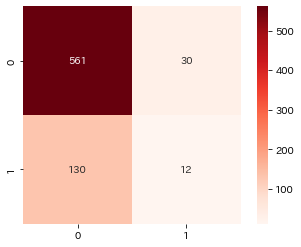

In [259]:
#描画テスト
df = c1
y_true = list(df[c_tag[0]])#評価指標に用いる列を指定し、リスト化
y_pred = list(df[c_tag[1]])#評価指標に用いる列を指定し、リスト化

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Reds',fmt='d')
# plt.savefig('sklearn_confusion_matrix.png')
# plt.savefig(path_file)

In [205]:
def get_cm(df_input, path_folder, name_file, col_names = list, suffix = str):
    """
    df_input:実測値と予測値を含むDF
    col_names:実測値と予測値の列名
    混合行列の図を返す
    """
    df = df_input.copy()
    y_true =list(df[col_names[0]])#実測ラベル
    y_pred =list(df[col_names[1]])#予測ラベル
    labels = sorted(list(set(y_true) | set(y_pred)))# ラベルの順序を指定
    cm = confusion_matrix(y_true, y_pred, labels=labels) # 混同行列の取得&ラベル順序指定
    fig =plt.figure (figsize = (6.4, 4.8))
    sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Reds',fmt='d')
    plt.ylabel('実測値', fontsize=13)
    plt.xlabel('予測値', fontsize=13)
    fig.savefig('{p}/{n}_混合行列_{s}.png'.format(p = path_folder, n = name_file, s = suffix), format="png", dpi=300)
    plt.clf()#メモリ解放
    plt.close(fig)
    return fig

In [280]:
suf = 'lgb'

In [282]:
get_cm(c1, path_folder, name_file, col_names = c_tag, suffix = '新人分類モデル_{}'.format(suf))

<Figure size 460.8x345.6 with 0 Axes>

In [283]:
get_cm(c2, path_folder, name_file, col_names = c_tag, suffix = '経験分類モデル_{}'.format(suf))

<Figure size 460.8x345.6 with 0 Axes>

In [284]:
get_cm(r1, path_folder, name_file, col_names = r_tag, suffix = '新人回帰モデル_{}'.format(suf))

<Figure size 460.8x345.6 with 0 Axes>

In [285]:
get_cm(r2, path_folder, name_file, col_names = r_tag, suffix = '経験回帰モデル_{}'.format(suf))

<Figure size 460.8x345.6 with 0 Axes>

## 集計

In [300]:
#結果出力
c1 = get_result_test_clf(df_prets[1],1)#新人分類モデルの検証結果
c2 = get_result_test_clf(df_prets[2],2)#経験分類モデルの検証結果

c_tag=['実測値','予測値']#y_true, y_pred

r1 = get_result_test_reg(df_prets[1],1)#新人回帰モデルの検証結果
r2 = get_result_test_reg(df_prets[2],2)#経験回帰モデルの検証結果

r_tag=['実測値ランク','予測値ランク']#y_true, y_pred

/Users/s.ogura/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/s.ogura/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/s.ogura/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/s.ogura/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please cha

In [301]:
c1.columns.values

array(['学年', '年齢', '偏差値', '採否時登録時間', '依頼枚数', '登録試験点数', '参加回数', '科目', '分野',
       '身分', 'スタッフコード', '実測値', '予測値', '0の確信度', '1の確信度'], dtype=object)

In [302]:
c2.columns.values

array(['前回の完全一致率', '前回の枠更新率', '学年', '年齢', '偏差値', '採否時登録時間', '依頼枚数',
       '登録試験点数', '参加回数', '科目', '分野', '身分', 'スタッフコード', '実測値', '予測値',
       '0の確信度', '1の確信度'], dtype=object)

In [ ]:
#データフレームをコピー
#0の確信度の上位95％, 90％, 80％, 70％の値を取得
#上位95％の値を持つレコードを抽出し、新しいdfにする
#各dfの枠更新率0.99以下の人数/全体の人数を出す

In [348]:
def calc_99(df_input):
    """
    データフレームをコピー
    0の確信度の上位X％の値を持つレコードを抽出し、新しいdfにする
    各dfの枠更新率0.99以下の人数/全体の人数を出す
    """
    df = df_input.copy()    
    #下位X%の値を取得する
    thresholds = df['0の確信度'].quantile([0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    res = []
    # for i in thresholds:
    for i, value in enumerate(thresholds):
        df_temp = df[df['0の確信度'] >= value]
        res.append(len(df_temp[df_temp['実測値']==1]) / len(df_temp))
        print(len(df_temp),len(df_temp[df_temp['実測値']==1]),round(res[i], 3))
    return res

In [349]:
test = calc_99(c1)

733 142 0.194
696 131 0.188
659 124 0.188
586 109 0.186
513 90 0.175
440 79 0.18
367 65 0.177
293 46 0.157
220 37 0.168
147 27 0.184
74 13 0.176


In [350]:
test = calc_99(c2)

1677 218 0.13
1593 200 0.126
1509 189 0.125
1341 162 0.121
1174 132 0.112
1006 107 0.106
839 87 0.104
671 73 0.109
503 57 0.113
336 40 0.119
168 13 0.077


# メモ

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues',fmt='d')
plt.savefig('sklearn_confusion_matrix.png')

In [ ]:
from sklearn.metrics import confusion_matrix
y_true = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]#リストで作成
y_pred = [0, 1, 1, 1, 1, 0, 0, 0, 1, 1]#リストで作成

cm = confusion_matrix(y_true, y_pred)

In [28]:
def get_graph(df_input,case=int):
    df = df_input.copy()
    path_folder = r"/Users/s.ogura/Documents/CRLEA/data/output"#フォルダパス
    #新人モデルの結果
    if case == 0:
        dfs=[[],[],[]]
        dfs[0] = make_data_shinjin(df,val=0)
        dfs[1] = make_data_shinjin2(df,val=0)
        dfs[2] = make_data_shinjin3(df,val=0)
        models = [[],[],[]]
        for i in range(0,len(dfs)):
            model = train_model(dfs[i],a=2,b=1,c=None)
            res = get_importance(dfs[i], model)
            name = "採点者品質予測_科目混合_完全一致率_重要度_新人{}_0902_v1".format(i)#ファイル名
            path_file = r'{p}/{n}'.format(p = path_folder, n = name)#ファイルパスとファイル名
            res.savefig('{p}/{n}.png'.format(p = path_folder, n = name), format="png", dpi=300)
            treegraph = make_treegraph(dfs[i], model)
            name = "採点者品質予測_科目混合_完全一致率_樹形図_新人{}_0902_v1".format(i)#ファイル名
            path_file = r'{p}/{n}'.format(p = path_folder, n = name)#ファイルパスとファイル名
            treegraph.render(path_file)

    #経験者モデルの結果
    elif case == 1:
        dfs=[[],[],[]]
        dfs[0] = make_data_keiken(df,val=0)
        dfs[1] = make_data_keiken2(df,val=0)
        dfs[2] = make_data_keiken3(df,val=0)
        models = [[],[],[]]
        for i in range(0,len(dfs)):
            model = train_model(dfs[i],a=2,b=1,c=None)
            res = get_importance(dfs[i], model)
            name = "採点者品質予測_科目混合_完全一致率_重要度_経験{}_0902_v1".format(i)#ファイル名
            path_file = r'{p}/{n}'.format(p = path_folder, n = name)#ファイルパスとファイル名
            res.savefig('{p}/{n}.png'.format(p = path_folder, n = name), format="png", dpi=300)
            treegraph = make_treegraph(dfs[i], model)
            name = "採点者品質予測_科目混合_完全一致率_樹形図_経験{}_0902_v1".format(i)#ファイル名
            path_file = r'{p}/{n}'.format(p = path_folder, n = name)#ファイルパスとファイル名
            treegraph.render(path_file)
            
    return

In [82]:
#結果出力
target_names = ['0','1'] #閾値以上が0, 閾値以下が1
a=['実測値','予測値']#y_true, y_pred
df1 = df_test#モデルの検証結果

with pd.ExcelWriter('{}/{}.xlsx'.format(path_folder,name_file)) as writer:
    df1.to_excel(writer, sheet_name='22夏検証_test',encoding='utf-8-sig', index = False)
    pd.DataFrame(classification_report(y_true = list(df1[a[0]]),
                                       y_pred = list(df1[a[1]]),
                                       target_names=target_names,output_dict=True)).to_excel(writer, sheet_name='22夏検証_test_score',encoding='utf-8-sig', index = True)

In [55]:
#結果出力
target_names = ['0.70~0.95', '~0.70', '0.95~']
a=['実測一致率ランク','想定一致率ランク']#y_true, y_pred
df1 = get_result_test(df_pret_shinjin, case = 0)#新人モデルの検証結果
df2 = get_result_test(df_pret_keiken, case = 1)#経験モデルの検証結果
df3 = get_result_test(df_pret_etc, case = 0)#経験（過去データなし）モデルの検証結果 新人モデルと同じ学習法で、データセットだけ変えてある

df1_pred = get_result_pred(df_pret_shinjin, case = 0)#新人モデルの予測結果
df2_pred = get_result_pred(df_pret_keiken, case = 1)#経験モデルの予測結果
df3_pred = get_result_pred(df_pret_etc, case = 0)#経験（過去データなし）モデルの予測結果


name_file = "採点者品質予測_22冬_予測値_1227_v2" #ファイル名
path_folder = r"/Users/s.ogura/Documents/CRLEA/data/output"#フォルダパス
path_file = r'{p}/{n}'.format(p = path_folder, n = name_file)#ファイルパスとファイル名

with pd.ExcelWriter('{}/{}.xlsx'.format(path_folder,name_file)) as writer:
    df1_pred.to_excel(writer, sheet_name='予測_新人_分野',encoding='utf-8-sig', index = False)
    df2_pred.to_excel(writer, sheet_name='予測_経験_分野',encoding='utf-8-sig', index = False)
    df3_pred.to_excel(writer, sheet_name='予測_経験過去無し_分野',encoding='utf-8-sig', index = False)
    df1.to_excel(writer, sheet_name='22夏検証_新人_分野',encoding='utf-8-sig', index = False)
    df2.to_excel(writer, sheet_name='22夏検証_経験_分野',encoding='utf-8-sig', index = False)
    df3.to_excel(writer, sheet_name='22夏検証_経験過去無し_分野',encoding='utf-8-sig', index = False)
    pd.DataFrame(classification_report(y_true = list(df1[a[0]]),
                                       y_pred = list(df1[a[1]]),
                                       target_names=target_names,output_dict=True)).to_excel(writer, sheet_name='22夏検証_新人_分野_score',encoding='utf-8-sig', index = True)
    pd.DataFrame(classification_report(y_true = list(df2[a[0]]),
                                       y_pred = list(df2[a[1]]),
                                       target_names=target_names,output_dict=True)).to_excel(writer, sheet_name='22夏検証_経験_分野_score',encoding='utf-8-sig', index = True)
    pd.DataFrame(classification_report(y_true = list(df3[a[0]]),
                                       y_pred = list(df3[a[1]]),
                                       target_names=target_names,output_dict=True)).to_excel(writer, sheet_name='22夏検証_経験過去無し_分野_score',encoding='utf-8-sig', index = True)

In [10]:
#結果の評価

In [11]:
#結果出力